# Run FaIR v2.1 with RFF scenarios

- use all 10000 emissions scenarios
- select 100 ensemble members at random per run
- infill non-CO2, non-CH4, non-N2O with SSP2-4.5
- stochastic variability is ON

In [1]:
from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties
from fair.forcing.ghg import meinshausen2020

from tqdm.autonotebook import tqdm
import numpy as np
import pandas as pd
import copy
import random
import matplotlib.pyplot as pl
import xarray as xr
import os

In [2]:
os.makedirs('../data_output/stochastic', exist_ok=True)

In [3]:
erf_2co2 = meinshausen2020(
    np.array([554.30, 731.41, 273.87]) * np.ones((1, 1, 1, 3)),
    np.array([277.15, 731.41, 273.87]) * np.ones((1, 1, 1, 3)),
    np.array((1.05, 0.86, 1.07)) * np.ones((1, 1, 1, 1)),
    np.ones((1, 1, 1, 3)),
    np.array([True, False, False]),
    np.array([False, True, False]),
    np.array([False, False, True]),
    np.array([False, False, False])
).squeeze()[0]
erf_2co2

3.9334694485974606

In [4]:
n_scen = 10000

In [5]:
df_forc = pd.read_csv('../data_input/table_A3.3_historical_ERF_1750-2019_best_estimate.csv')
df_solar = pd.read_csv('../data_input/solar_erf.csv', index_col='year')

In [6]:
species, properties = read_properties()

In [7]:
df_configs = pd.read_csv('../data_input/ar6_calibration_ebm3.csv', index_col=0)
configs = np.array(list(df_configs.index))
print(configs)

[   2886    4504    6472 ... 1490293 1496637 1498879]


In [8]:
seed = 1355763 + 399 * np.array(configs)

In [9]:
scenarios = list(range(1, n_scen+1))

In [10]:
seedgen = 1355763
seedstep = 399

In [11]:
da_emissions = xr.load_dataarray('../data_input/ssp_emissions_fair2.1.nc')

In [12]:
trend_shape = np.ones(552)
trend_shape[:271] = np.linspace(0, 1, 271)

In [13]:
solar_forcing = np.zeros(552)
solar_forcing[:550] = df_solar['solar_erf'].loc[1750.5:2300].values
volcanic_forcing = np.zeros(552)
volcanic_forcing[:270] = df_forc['volcanic'].values
volcanic_forcing[269:281] = np.linspace(1, 0, 12) * volcanic_forcing[269]

In [14]:
#del temp_out, ohc_out, erf_out, co2_out, ch4_out, n2o_out

In [15]:
scenarios

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [16]:
n_ens = 100

calibrated_f4co2_mean = df_configs['F_4xCO2'].mean()

for i_scen in tqdm(range(n_scen)):
    # Draw 100 configs at random
    random.seed(i_scen)
    choose = np.array(random.sample(range(1001), n_ens))
    config_sample = configs[choose]
    f = FAIR(ch4_method='Thornhill2021')
    f.define_time(1750, 2301, 1)
    f.define_scenarios([i_scen+1])
    f.define_configs(config_sample)
    f.define_species(species, properties)
    f.allocate()

    # emissions and forcing
    da = da_emissions.loc[dict(config='unspecified', scenario='ssp245')][:551, ...]
    fe = da.expand_dims(dim=['scenario', 'config'], axis=(1,2))
    f.emissions = fe.drop('config') * np.ones((1,1,n_ens,1))  # for everything that's not CO2, CH4 and N2O
    f.emissions['scenario'] = [i_scen+1]
    f.emissions['config'] = config_sample
    
    df = pd.read_csv('../data_processed/emissions_files/emissions%05d.csv' % (i_scen+1), index_col=0)
    # RFF scenarios provide total CO2; we want to back out the fossil component
    f.emissions.loc[dict(specie='CO2 FFI')] = df.loc[:,'CO2'].values[:,None,None] - f.emissions.loc[dict(specie='CO2 AFOLU')]
    f.emissions.loc[dict(specie='CH4')] = df.loc[:,'CH4'].values[:,None,None]
    f.emissions.loc[dict(specie='N2O')] = df.loc[:,'N2O'].values[:,None,None]
    
    fill(
        f.forcing, 
        volcanic_forcing[:, None, None] * df_configs.loc[config_sample, 'scale Volcanic'].values.squeeze(), 
        specie='Volcanic'
    )
    fill(
        f.forcing, 
        solar_forcing[:, None, None] * 
        df_configs.loc[config_sample, 'solar_amplitude'].values.squeeze() + 
        trend_shape[:, None, None] * df_configs.loc[config_sample, 'solar_trend'].values.squeeze(),
        specie='Solar'
    )

    # climate configs
    fill(f.climate_configs['ocean_heat_capacity'], df_configs.loc[config_sample, 'c1':'c3'].values)
    fill(f.climate_configs['ocean_heat_transfer'], df_configs.loc[config_sample, 'kappa1':'kappa3'].values)
    fill(f.climate_configs['deep_ocean_efficacy'], df_configs.loc[config_sample, 'epsilon'].values.squeeze())
    fill(f.climate_configs['gamma_autocorrelation'], df_configs.loc[config_sample, 'gamma'].values.squeeze())
    fill(f.climate_configs['sigma_eta'], df_configs.loc[config_sample, 'sigma_eta'].values.squeeze())
    fill(f.climate_configs['sigma_xi'], df_configs.loc[config_sample, 'sigma_xi'].values.squeeze())
    fill(f.climate_configs['seed'], seed[choose])
    fill(f.climate_configs['stochastic_run'], True)
    fill(f.climate_configs['use_seed'], True)
    fill(f.climate_configs['forcing_4co2'], 2 * erf_2co2 * (1 + 0.561*(calibrated_f4co2_mean - df_configs.loc[config_sample,'F_4xCO2'])/calibrated_f4co2_mean))
    
    # species configs
    f.fill_species_configs()
    
    # carbon cycle
    fill(f.species_configs['iirf_0'], df_configs.loc[config_sample, 'r0'].values.squeeze(), specie='CO2')
    fill(f.species_configs['iirf_airborne'], df_configs.loc[config_sample, 'rA'].values.squeeze(), specie='CO2')
    fill(f.species_configs['iirf_uptake'], df_configs.loc[config_sample, 'rU'].values.squeeze(), specie='CO2')
    fill(f.species_configs['iirf_temperature'], df_configs.loc[config_sample, 'rT'].values.squeeze(), specie='CO2')

    # aerosol indirect
    fill(f.species_configs['aci_scale'], df_configs.loc[config_sample, 'beta'].values.squeeze())
    fill(f.species_configs['aci_shape'], df_configs.loc[config_sample, 'shape_so2'].values.squeeze(), specie='Sulfur')
    fill(f.species_configs['aci_shape'], df_configs.loc[config_sample, 'shape_bc'].values.squeeze(), specie='BC')
    fill(f.species_configs['aci_shape'], df_configs.loc[config_sample, 'shape_oc'].values.squeeze(), specie='OC')
    
    # methane lifetime baseline
    fill(f.species_configs['unperturbed_lifetime'], 10.4198121, specie='CH4')
    
    # emissions adjustments for N2O and CH4 (we don't want to make these defaults as people might wanna run pulse expts with these gases)
    fill(f.species_configs['baseline_emissions'], 19.019783117809567, specie='CH4')
    fill(f.species_configs['baseline_emissions'], 0.08602230754, specie='N2O')
    
    # aerosol direct
    for specie in ['BC', 'CH4', 'N2O', 'NH3', 'NOx', 'OC', 'Sulfur', 'VOC', 'Equivalent effective stratospheric chlorine']:
        fill(f.species_configs['erfari_radiative_efficiency'], df_configs.loc[config_sample, f"ari {specie}"], specie=specie)

    # forcing
    for specie in ['CH4', 'N2O', 'Stratospheric water vapour', 'Contrails', 'Light absorbing particles on snow and ice', 'Land use']:
        fill(f.species_configs['forcing_scale'], df_configs.loc[config_sample, f"scale {specie}"].values.squeeze(), specie=specie)
    for specie in ['CFC-11', 'CFC-12', 'CFC-113', 'CFC-114', 'CFC-115', 'HCFC-22', 'HCFC-141b', 'HCFC-142b',
        'CCl4', 'CHCl3', 'CH2Cl2', 'CH3Cl', 'CH3CCl3', 'CH3Br', 'Halon-1211', 'Halon-1301', 'Halon-2402',
        'CF4', 'C2F6', 'C3F8', 'c-C4F8', 'C4F10', 'C5F12', 'C6F14', 'C7F16', 'C8F18', 'NF3', 'SF6', 'SO2F2',
        'HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa', 'HFC-32',
        'HFC-365mfc', 'HFC-4310mee']:
        fill(f.species_configs['forcing_scale'], df_configs.loc[config_sample, 'scale minorGHG'].values.squeeze(), specie=specie)
    fill(f.species_configs['forcing_scale'], 1 + 0.561*(calibrated_f4co2_mean - df_configs.loc[config_sample,'F_4xCO2'].values)/calibrated_f4co2_mean, specie='CO2')

    # ozone
    for specie in ['CH4', 'N2O', 'CO', 'NOx', 'VOC', 'Equivalent effective stratospheric chlorine']:
        fill(f.species_configs['ozone_radiative_efficiency'], df_configs.loc[config_sample, f"o3 {specie}"], specie=specie)

    # tune down volcanic efficacy
    fill(f.species_configs['forcing_efficacy'], 0.6, specie='Volcanic')
    
    # initial condition of CO2 concentration (but not baseline for forcing calculations)
    fill(f.species_configs['baseline_concentration'], df_configs.loc[config_sample, 'co2_concentration_1750'].values.squeeze(), specie='CO2')

    # initial conditions
    initialise(f.concentration, f.species_configs['baseline_concentration'])
    initialise(f.forcing, 0)
    initialise(f.temperature, 0)
    initialise(f.cumulative_emissions, 0)
    initialise(f.airborne_emissions, 0)

    f.run(progress=False)

    
    # at this point dump out some batch output
    temp_out = f.temperature[:, 0, :, 0].data
    ohc_out = f.ocean_heat_content_change[:, 0, :].data
    erf_out = f.forcing_sum[:, 0, :].data
    co2_out = f.concentration[:, 0, :, 2].data
    ch4_out = f.concentration[:, 0, :, 3].data
    n2o_out = f.concentration[:, 0, 0, 4].data
    
    ds = xr.Dataset(
        {
            "temperature": (["year", "run"], temp_out - temp_out[100:151, :].mean(axis=0)),
            "effective_radiative_forcing": (["year", "run"], erf_out),
            "ocean_heat_content_change": (["year", "run"], ohc_out),
            "co2_concentration": (["year", "run"], co2_out),
            "ch4_concentration": (["year", "run"], ch4_out),
            "n2o_concentration": (["year"], n2o_out),
        },
        coords={
            "year": (np.arange(1750, 2301.5)),
            "run": config_sample
        },
    )
    ds.to_netcdf('../data_output/stochastic/run%05d.nc' % (i_scen+1))
    ds.close()

  0%|          | 0/10000 [00:00<?, ?it/s]

\\hdrive\home$\u045\smithc\git\chrisroadmap\fair2.1-calibrate\src\fair\forcing\ghg.py:268: RuntimeWarning: invalid value encountered in log
  * np.log(co2 / co2_base)
\\hdrive\home$\u045\smithc\git\chrisroadmap\fair2.1-calibrate\src\fair\forcing\ghg.py:280: RuntimeWarning: invalid value encountered in sqrt
  (a2 * np.sqrt(co2) + b2 * np.sqrt(n2o) + c2 * np.sqrt(ch4) + d2)
\\hdrive\home$\u045\smithc\git\chrisroadmap\fair2.1-calibrate\src\fair\forcing\ghg.py:268: RuntimeWarning: invalid value encountered in log
  * np.log(co2 / co2_base)
\\hdrive\home$\u045\smithc\git\chrisroadmap\fair2.1-calibrate\src\fair\forcing\ghg.py:280: RuntimeWarning: invalid value encountered in sqrt
  (a2 * np.sqrt(co2) + b2 * np.sqrt(n2o) + c2 * np.sqrt(ch4) + d2)
\\hdrive\home$\u045\smithc\git\chrisroadmap\fair2.1-calibrate\src\fair\forcing\ghg.py:268: RuntimeWarning: invalid value encountered in log
  * np.log(co2 / co2_base)
\\hdrive\home$\u045\smithc\git\chrisroadmap\fair2.1-calibrate\src\fair\forcing\ghg.

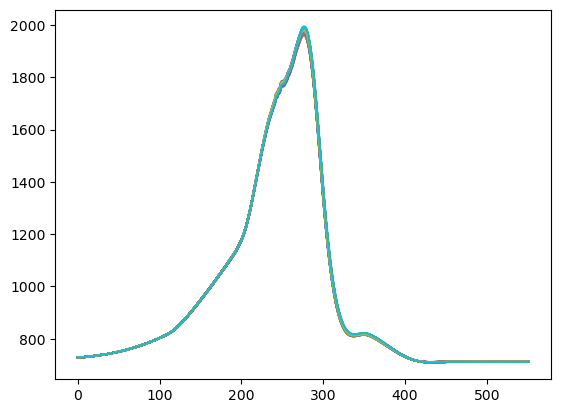

In [17]:
pl.plot(ch4_out);

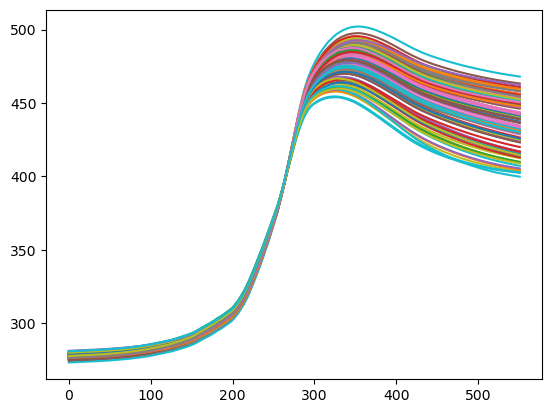

In [18]:
pl.plot(co2_out);

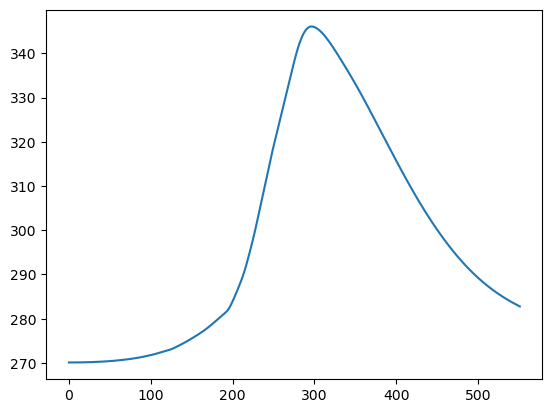

In [19]:
pl.plot(n2o_out);

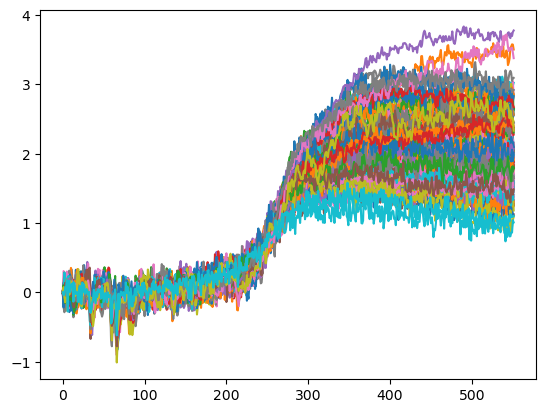

In [20]:
pl.plot(temp_out);

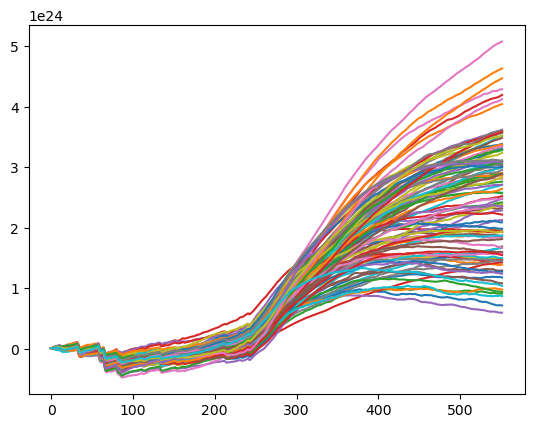

In [21]:
pl.plot(ohc_out);

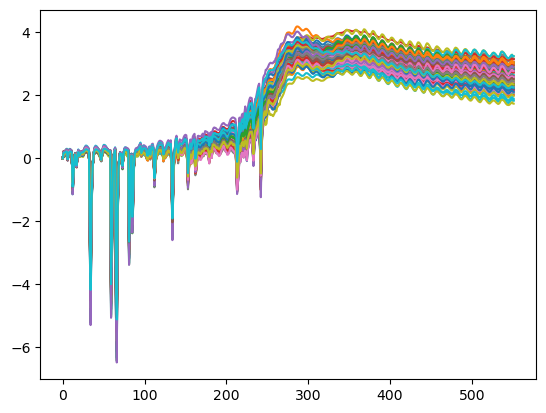

In [22]:
pl.plot(erf_out);